<a href="https://colab.research.google.com/github/matteolimoncini/glasses_or_no_glasses/blob/develop/Glasses_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing usefull libraries

In [26]:
%%capture
!pip install dask
!python -m pip install 'fsspec>=0.3.3'
!pip install --user kaggle

Import modules

In [2]:
import os
import shutil
from dask import dataframe as dd 
import tensorflow as tf
from random import randrange
import matplotlib.pyplot as plt

In [3]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


Setting fixed variables

In [4]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
#probably useless
#!export KAGGLE_USERNAME=matteolimoncini
#!export KAGGLE_KEY=c4df437bb6e9108ad29ae9744b503c89

Setting kaggle API

In [ ]:
!mkdir /root/.kaggle
!echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

Download and unzip dataset

In [ ]:
%%capture
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses
!unzip glasses-or-no-glasses.zip -d glasses-or-no-glasses

Reading training data using dask, that it's usefull because doesn't store in memory all the csv but use batch approach

Create two directories, one for images with glasses and another one for images without glasses

In [8]:
original_path = './glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/'

In [9]:
path = './img/glasses'
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
path = './img/no-glasses'
if not os.path.exists(path):
    os.makedirs(path)

In [11]:
# read csv that associate image and id
train_latent = dd.read_csv("./glasses-or-no-glasses/train.csv")

In [12]:
# variables used to count how much images have glasses or not
num_glasses = 0
num_no_glasses = 0

# splitting images in two folders: glasses and no glasses
for glasses_label in train_latent[['id','glasses']].iterrows():
  str_img = "face-"+str(glasses_label[1]['id'])+".png"
  old_path = original_path+str_img
  if (glasses_label[1]['glasses'] == 0):
    new_dir = "img/no-glasses"
    num_glasses += 1
  else:
    new_dir = "img/glasses"
    num_no_glasses += 1
  shutil.copy(old_path, new_dir)

In [13]:
print("Number of images used: " + str(len(train_latent)))
print("Number of images with glasses: " + str(num_glasses))
print("Number of images without glasses: " + str(num_no_glasses))

Number of images used: 4500
Number of images with glasses: 1644
Number of images without glasses: 2856


In [14]:
perc_glasses=round(num_glasses/len(train_latent)*100,2)
perc_no_glasses=round(num_no_glasses/len(train_latent)*100,2)
print("Dataset has "+ str(perc_glasses) + "% of images with glasses and " + str(perc_no_glasses) + "% without glasses")

Dataset has 36.53% of images with glasses and 63.47% without glasses


Dataset is not so unbalanced

In [15]:
training_dir = "img"

In [16]:
#resize in 64x64x3 images, training set
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                    validation_split = 0.1,
                                                                    subset="training",
                                                                    labels='inferred', label_mode='binary', 
                                                                    image_size=(64, 64), batch_size=128,
                                                                    seed = 123,
                                                                    smart_resize = True)

#resize in 64x64x3 images, validation set
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                    validation_split = 0.1,
                                                                    subset="validation",
                                                                    labels='inferred', label_mode='binary', 
                                                                    image_size=(64, 64), batch_size=128,
                                                                    seed = 123,
                                                                    smart_resize = True)

Found 4500 files belonging to 2 classes.
Using 4050 files for training.
Found 4500 files belonging to 2 classes.
Using 450 files for validation.


Check that labels are correct

In [17]:
class_names = train_dataset.class_names
class_names

['glasses', 'no-glasses']

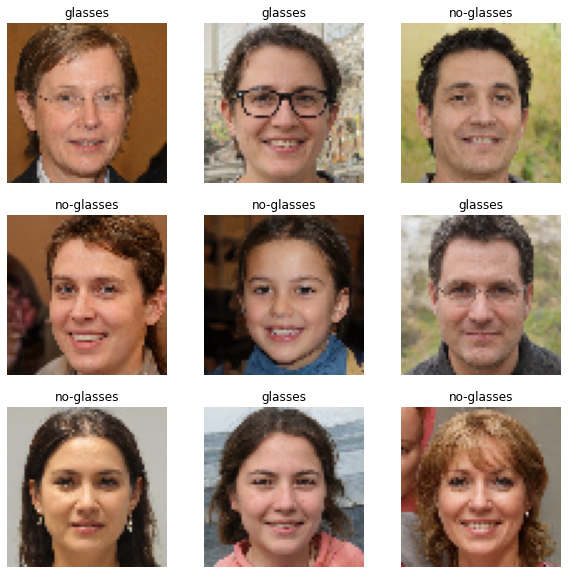

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[int(labels.numpy()[i])])
    plt.axis("off")

In [19]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# normalizing data

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
print(normalized_train_ds)

<MapDataset shapes: ((None, 64, 64, 3), (None, 1)), types: (tf.float32, tf.float32)>


In [21]:
#@title Boring code useful to plot [RUN ME]

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)

In [22]:
img_height = 64
img_width = 64
model = tf.keras.Sequential(
  [
      tf.keras.layers.InputLayer(input_shape=(64,64,3,)),
      tf.keras.layers.Reshape((64*64*3,), input_shape=((64,64,3,))),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
#plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12289     
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [23]:
epochs=20
history = model.fit(
  normalized_train_ds,
  validation_data=val_dataset,
  epochs=epochs, verbose = 1
)

Epoch 1/20
32/32 - 160s - loss: 0.6959 - accuracy: 0.5563 - val_loss: 57.0611 - val_accuracy: 0.5978
Epoch 2/20
32/32 - 0s - loss: 0.6756 - accuracy: 0.6296 - val_loss: 64.1574 - val_accuracy: 0.6067
Epoch 3/20
32/32 - 0s - loss: 0.6707 - accuracy: 0.6338 - val_loss: 63.4524 - val_accuracy: 0.6067
Epoch 4/20
32/32 - 0s - loss: 0.6660 - accuracy: 0.6351 - val_loss: 57.9985 - val_accuracy: 0.6067
Epoch 5/20
32/32 - 0s - loss: 0.6618 - accuracy: 0.6346 - val_loss: 61.0770 - val_accuracy: 0.6133
Epoch 6/20
32/32 - 0s - loss: 0.6577 - accuracy: 0.6356 - val_loss: 58.7279 - val_accuracy: 0.6133
Epoch 7/20
32/32 - 0s - loss: 0.6538 - accuracy: 0.6358 - val_loss: 57.9825 - val_accuracy: 0.6133
Epoch 8/20
32/32 - 0s - loss: 0.6501 - accuracy: 0.6373 - val_loss: 55.2630 - val_accuracy: 0.6133
Epoch 9/20
32/32 - 0s - loss: 0.6466 - accuracy: 0.6375 - val_loss: 55.3886 - val_accuracy: 0.6133
Epoch 10/20
32/32 - 0s - loss: 0.6431 - accuracy: 0.6378 - val_loss: 56.4849 - val_accuracy: 0.6133
Epoch 1

Plot history of loss function in train and test set

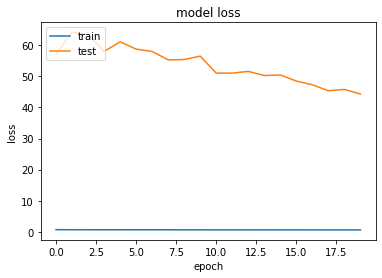

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot history of accuracy in train and test set

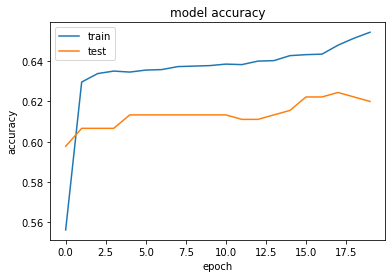

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()